<a href="https://colab.research.google.com/github/TuckerArrants/flower-classification/blob/master/Training%20on%20TPU%20with%20Flower%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flower Classification with TPUs

**There are many famous computer vision classification problems, like reading handwritten digits or distinguishing between cats and dogs, but all of these are tasks that a regular human can do. While it is impressive that we can build models to do these tasks as well as a human can, it would be more impressive to build a model that can can do something the average person can't do - like look at images of flowers and classify them into 104 different types**

**That is the task of this notebook. We have over 16,000 images in our training set and about 7,400 images to classify, which is around 5GB of data in total. I will also be performing some image augmentation, so as you can probably imagine, this will require some extra computational power** 

**To provide this power, we will use Cloud tensor processings units (TPUs) - hardware accelerators specifically designed for deep learning tasks. Google Colabs has free TPU access and no weekly quota, so I suggest training your models here**

**Before we begin, special thanks to the starter kernel which helped kickstart this notebook. It can be found [here](https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu). If you enjoy this notebook, please leave an upvote and feel free to comment with any questions/suggestions. Let's begin:**

# [Project](http://)

In [1]:
#the basics
from matplotlib import pyplot as plt
import math, os, re
import numpy as np
import pandas as pd

#deep learning basics
import tensorflow as tf
import tensorflow.keras.backend as K

#get current TensorFlow version fo
print("Currently using Tensorflow version " + tf.__version__)

Currently using Tensorflow version 2.2.0


# I. Configuration

**To take advantage of TPUs, we have to do some extra work. For the uninitiated, [this](http://www.tensorflow.org/guide/tpu) is an excellent place to start. We start by checking to see if TensorFlow is using a TPU or not - if it isn't, we set the 'strategy' to its default, which works on CPU and a single GPU, though we will definitely need to use the TPU for the current parameter setups of this notebook (if you use smaller image sizes, you might get away with running on CPU/GPU)**

In [2]:
#detect for TPU - don't need any parameters if TPU_NAME environment variable is set, which it always is on Kaggle
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())

#if no TPU is detected, turn set TPU to None
except ValueError:
    tpu = None

#if there is a tpu, connect to it and choose distribution strategy
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

#set to the default TensorFlow strategy if no TPU available
else:
    strategy = tf.distribute.get_strategy()
print("# of replicas: ", strategy.num_replicas_in_sync)
#if the number of replicas = 8, you are officially using TPUs

Running on TPU  grpc://10.100.71.226:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.100.71.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.100.71.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# of replicas:  8


**TPUs read data directly from Google Cloud Storage (GCS), so we actually need to copy our dataset to a GCS 'bucket' that is near or 'co-located' with the TPU. The below chunk of code accomplishes this using the handy kaggle_datasets:** 

In [3]:
#get GCS path for flower classification data set
GCS_DS_PATH = 'gs://kds-d7e754c065754455c772a9ed9418bb21d44d32f1f94aa1885c92db7a'

**To optimize the TPUs bandwith, we cut our dataset into files and then send these files to the different TPU cores. The common format for these files is TFRecords which essentially just takes the pixels of the image and some other information (e.g. a label) and stuffs it into a file. A good number of TFRecord files is 16: so we take our dataset and split it into 16 different TFRecord files and send them to the TPUs**

**Note: we need to modify some parameters accordingly because of this, most notably, we need to multiply whatever batch size we intend to use for our model(s) by 16**

In [4]:
#for reproducibility
SEED = 34     #my favorite number

#define image size we will use
IMAGE_SIZE = [331, 331]               #to make this commit faster
#IMAGE_SIZE = [192, 192]               #if you aren't using TPU
#IMAGE_SIZE = [512, 512]               #if you are using TPU

#how many training samples we want going to TPUs 
BATCH_SIZE = 16 * strategy.num_replicas_in_sync 

#how many folds we will use to train our model on
FOLDS = 3

#option to train on one fold in case we want to use larger models
FIRST_FOLD_ONLY = True

#list other options we have for image sizes
GCS_PATH_SELECT = {
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}

#choose 512 image size for best performance
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

**For more about getting your data into TFRecord format for TPU processing, see [here](http://www.tensorflow.org/tutorials/load_data/tfrecord)**



In [5]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels = 3)
    #convert image to floats between 0 and 1
    image = tf.cast(image, tf.float32) / 255.0
    #size needed for TPU
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    
    #returns a dataset of (image, label) pairs
    return image, label

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # [] means single entry
    }
    
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    #returns a dataset of image(s)
    return image, idnum 

**And now we just take the above defined functions and broadcast them across our different datasets. There is also a `data_augment` function and `if_aug` parameters which are to prepare us for when we add image augmentation to our model. For a quick reference on using `tf.image` to perform image augmentation, see [this](http://www.tensorflow.org/tutorials/images/data_augmentation)**

**Note: to achieve peak performance, we can use a pipeline that 'prefetches' data for the next step before the current step has finished using `tf.data`. You can learn more [here](http://www.tensorflow.org/guide/data_performance)**

In [6]:
#define pre fetching strategy
AUTO = tf.data.experimental.AUTOTUNE

def load_dataset(filenames, labeled = True, ordered = False):
    #order doesn't matter since we will be shuffling the data anyway
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    
    #automatically interleaves reads from multiple files
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    #use data as soon as it streams in, rather than in its original order
    dataset = dataset.with_options(ignore_order)
    #returns a dataset of (image, label) pairs if labeled = True or (image, id) pair if labeled = False
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO)
    return dataset

#some simply image augmentation we can perform with tf.image
def data_augment(image, label):
    
    #random augmentations
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_saturation(image, 0, 2)
    #image = tf.image.random_hue(image, max_delta = .2)
    #image = tf.image.random_brightness(image, max_delta = .2)
    
    #fixed augmentations
    #image = tf.image.adjust_saturation(image, max_delta = .2)
    #image = tf.image.central_crop(image, central_fraction = 0.5)
    return image, label   

def get_training_dataset(dataset,do_aug = True):
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    #the training dataset must repeat for several epochs
    dataset = dataset.repeat()
    #shuffle the samples to help with overfitting
    dataset = dataset.shuffle(2048)
    #set batch size
    dataset = dataset.batch(BATCH_SIZE)
    #optional augmentation parameter
    if do_aug: dataset = dataset.map(mixup_and_cutmix, num_parallel_calls = AUTO)
    #prefetch next batch while training (autotune prefetch buffer size)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(dataset, do_onehot = True):
    dataset = dataset.batch(BATCH_SIZE)
    #if we use down below augmentations - cutmix and mixup - we one hot encode
    if do_onehot: dataset = dataset.map(onehot, num_parallel_calls = AUTO)
    dataset = dataset.cache()
    #prefetch next batch while training (autotune prefetch buffer size)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered = False):
    dataset = load_dataset(TEST_FILENAMES, labeled = False, ordered = ordered)
    #set batch size
    dataset = dataset.batch(BATCH_SIZE)
    #prefetch next batch while training (autotune prefetch buffer size)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

#use tf.io.gfile.glob to find our training and test files from GCS bucket
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') + tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')
    
#show item counts
NUM_TRAINING_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (FOLDS-1.)/FOLDS )
NUM_VALIDATION_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (1./FOLDS) )
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 10976 training images, 5488 validation images, 7382 unlabeled test images


# II. Visualization

**Now that we have dealt with all the configuring required to use TPUs, we can extract our images from the TPU and finally get a look at our data:**

In [7]:
#define flower classes for labeling purposes
classes = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

**Define some helper functions to plot our flower images:**

In [8]:
#numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    #binary strings are image IDs
    if numpy_labels.dtype == object:
        numpy_labels = [None for _ in enumerate(numpy_images)]
    #If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return classes[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(classes[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                classes[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    #auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    #size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    #display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else classes[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #get optimal spacing
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [9]:
#first look at training dataset
training_dataset = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False)
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

In [10]:
#first look at test dataset
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

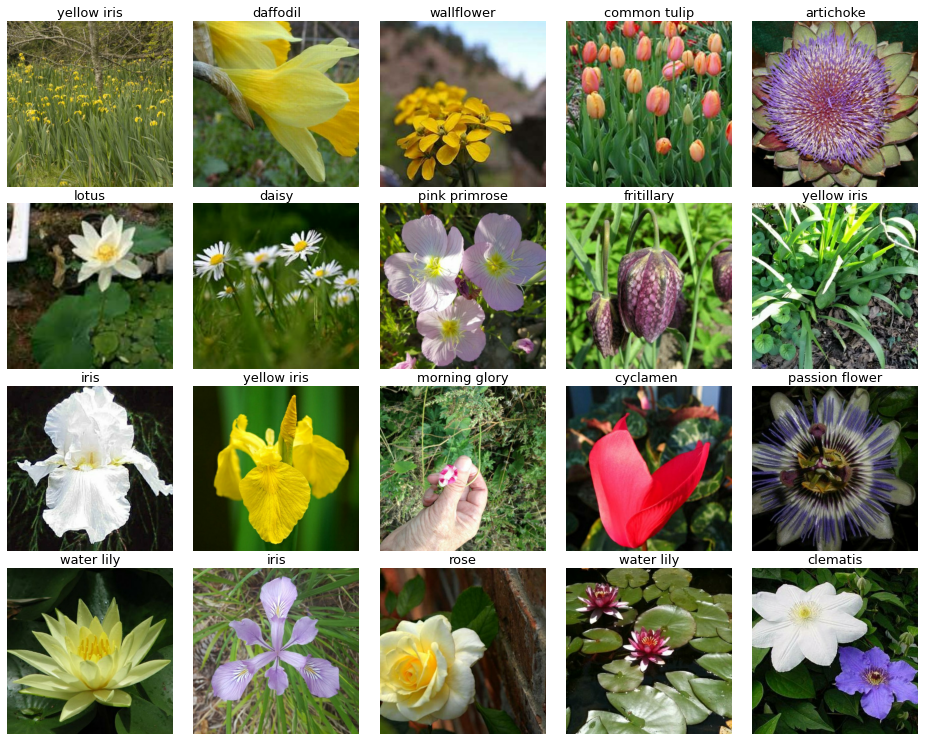

In [11]:
#view batch of flowers from train
display_batch_of_images(next(train_batch))
#you can run this cell again and it will load a new batch

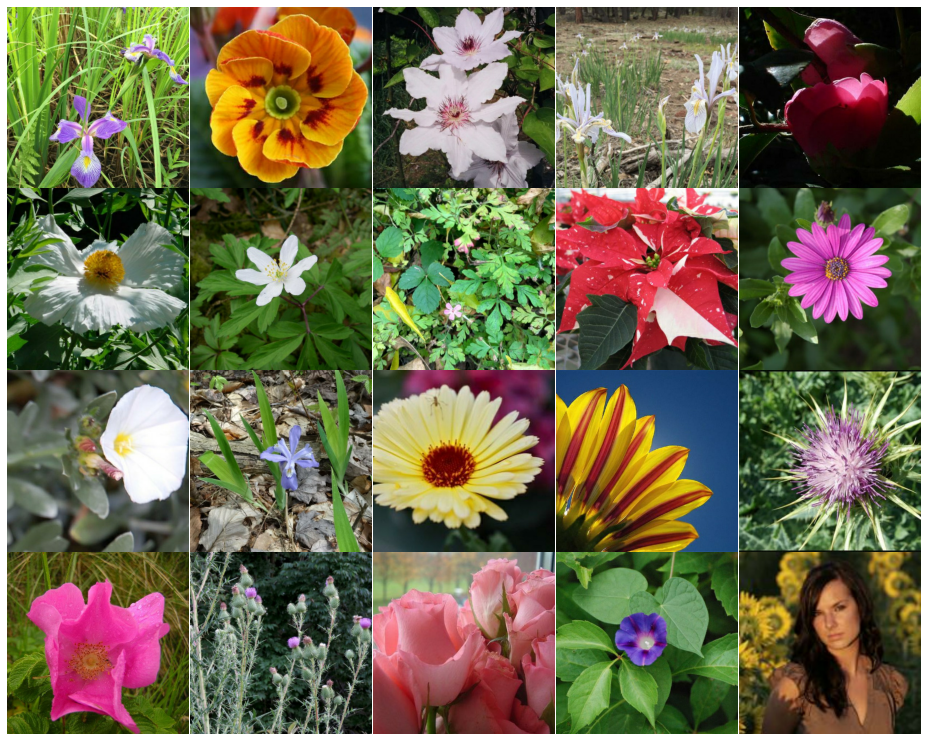

In [12]:
#view batch of flowers from test
display_batch_of_images(next(test_batch))
#you can run this cell again and it will load a new batch

# III. Augmentation

**Deep neural networks are incredibly powerful and often memorize data as opposed to learn data. To prevent overfitting, regularization techniques are implimented, such as dropout and l1/l2 regularization. We could use dropout, but this just removes informative pixels useful for training by blacking out pixels. Surely we can be more creative with image data than this:**

**Note: the following augmentation implementations are taken from (4X Kaggle Grandmaster) [Chris Deotte](https://www.kaggle.com/cdeotte)'s notebook, which can be found [here](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu)**

### mixup

**Now, the augmentation we did above is great, but we are still adding noise to the images which is also leading to information loss. Luckily, we can do better with mixup. Essentially, all mixup does is random converts images to convex combinations of pairs of images and their labels, as seen in the illustration below:**

![mixup](http://miro.medium.com/max/362/0*yLCQYAtNAh28LQks.png)
Image from [here](http://medium.com/swlh/how-to-do-mixup-training-from-image-files-in-keras-fe1e1c1e6da6)

**We can see that we retain information about both images and their labels while introducing regularization into our model. For more on MixUp, read [this](https://arxiv.org/abs/1710.09412)**

In [13]:
#need to one hot encode images so we can blend their labels like above
def onehot(image,label):
    CLASSES = len(classes)
    return image,tf.one_hot(label,CLASSES)

In [14]:
def mixup(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    DIM = IMAGE_SIZE[0]
    CLASSES = len(classes)
    imgs = []; labs = []
    for j in range(BATCH_SIZE):
        #do mixup with probability PROBABILITY
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
        #chose random number
        k = tf.cast( tf.random.uniform([],0,BATCH_SIZE),tf.int32)
        a = tf.random.uniform([],0,1)*P 
        #make mixup image
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
        #make cutmix label
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    #must explicitly reshape so TPU complier knows output shape
    image2 = tf.reshape(tf.stack(imgs),(BATCH_SIZE,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(BATCH_SIZE,CLASSES))
    return image2,label2

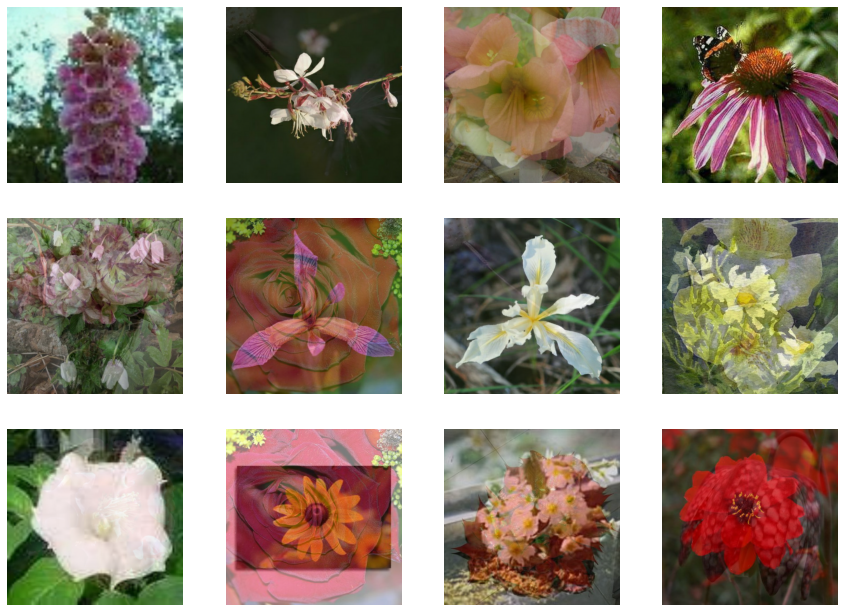

In [15]:
#view effects of mixup
row = 3; col = 4;
row = min(row,BATCH_SIZE//col)
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
augmented_element = all_elements.repeat().batch(BATCH_SIZE).map(mixup)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

### CutMix

**CutMix is essentially the same as mixup except the images are not blended together, rather a random sized block of one image is superimposed on another image. You can read more about it [here](http://arxiv.org/pdf/1905.04899.pdf)**

In [16]:
def cutmix(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IMAGE_SIZE[0]
    CLASSES = len(classes)
    
    imgs = []; labs = []
    for j in range(BATCH_SIZE):
        #do cutmix with probability PROBABILITY
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        #chose random image to cutmix with
        k = tf.cast( tf.random.uniform([],0,BATCH_SIZE),tf.int32)
        #chose random location
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        #make cutmix image
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        #make cutmix label
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    #must explicitly reshape so TPU complier knows output shape
    image2 = tf.reshape(tf.stack(imgs),(BATCH_SIZE,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(BATCH_SIZE,CLASSES))
    return image2,label2

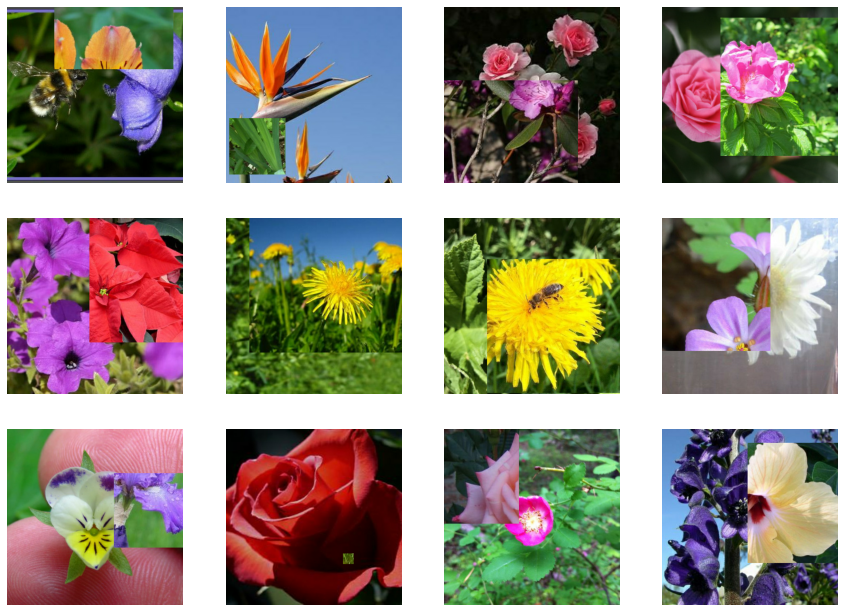

In [17]:
#view effects of cutmix
row = 3; col = 4;
row = min(row,BATCH_SIZE//col)
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
augmented_element = all_elements.repeat().batch(BATCH_SIZE).map(cutmix)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

### mixup and CutMix

**It is hard to choose which is better, mixup or CutMix. Luckily, we don't actually have to choose because we can just apply both:**

**Note: CutMix will occur `SWITCH * CUTMIX_PROB` of the time and mixup will occur `(1 - SWITCH) * MIXUP_PROB` of the time. We will need to experiment a bit to see which convex combination delivers the best performance**

**The current setup gives us mixup 33% of the time, CutMix 33% of the time, and no augmentation 33% of the time**

In [18]:
#create function to apply both cutmix and mixup
def mixup_and_cutmix(image,label):
    CLASSES = len(classes)
    DIM = IMAGE_SIZE[0]
    #define how often we want to do activate cutmix or mixup
    SWITCH = 1/2
    #define how often we want cutmix or mixup to activate when switch is active
    CUTMIX_PROB = 2/3
    MIXUP_PROB = 2/3
    #apply cutmix and mixup
    image2, label2 = cutmix(image, label, CUTMIX_PROB)
    image3, label3 = mixup(image, label, MIXUP_PROB)
    imgs = []; labs = []
    for j in range(BATCH_SIZE):
        P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
        imgs.append(P*image2[j,]+(1-P)*image3[j,])
        labs.append(P*label2[j,]+(1-P)*label3[j,])
    #must explicitly reshape so TPU complier knows output shape
    image4 = tf.reshape(tf.stack(imgs),(BATCH_SIZE,DIM,DIM,3))
    label4 = tf.reshape(tf.stack(labs),(BATCH_SIZE,CLASSES))
    return image4,label4

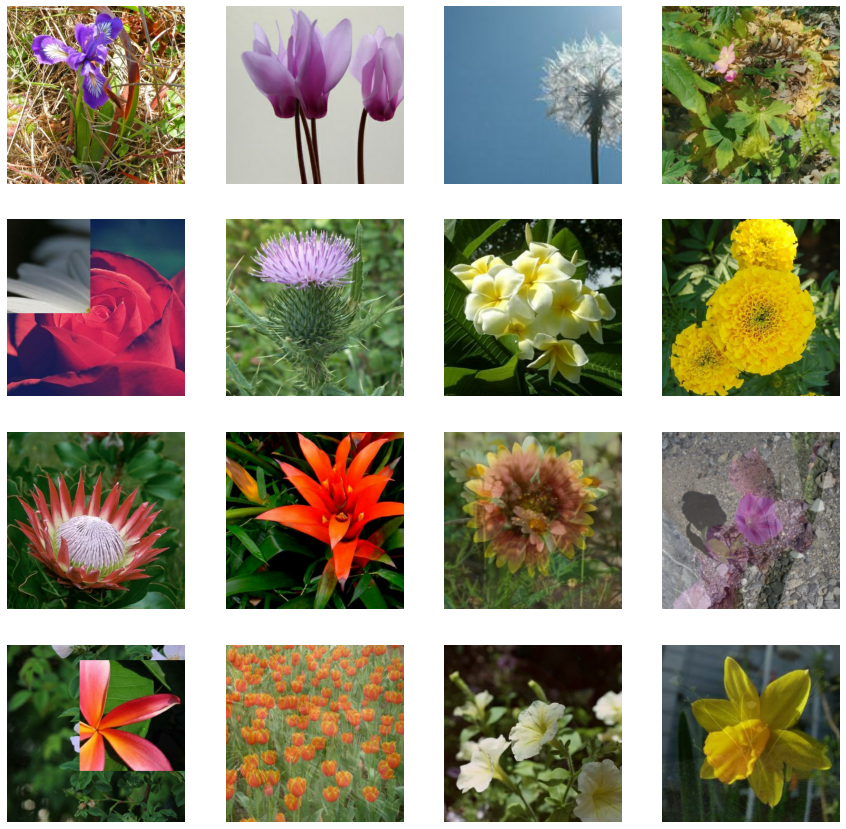

In [19]:
#view effects of cutmix/mixup
row = 4; col = 4;
row = min(row,BATCH_SIZE//col)
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug = False).unbatch()
augmented_element = all_elements.repeat().batch(BATCH_SIZE).map(mixup_and_cutmix)

for (img,label) in augmented_element:
    plt.figure(figsize = (15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break
    
#file_name = 'stylized-image.png'
#tensor_to_image(image).save(file_name)

# IV. Models, Training, and Submission

**Now, it will take far too much time for us to train a model ourselves to learn the optimal weights for classifying our flower photos, so we will instead import a model that has already been pre-trained on ImageNet: a large labeled dataset of real-world images**

**We will be importing several popular pre-trained models. For a list of all the pre-trained models that can be imported with Keras, see [here](https://keras.io/api/applications/)**

**We could just use the pre-trained weights as they are, or we could 'fine-tune' them by cleverly choosing a learning rate schedule for our model's training, but how do we do this?**

**Well, we can start with a low learning rate so that our weights don't update too far away from their initial values, and then increase the learning rate as our model trains. Then after allowing our model to explore other weights near its imported weights for a couple epochs, we bring the learning rate back down again to for the rest of training**

Learning rate schedule: 1e-05 to 0.0004 to 6.23e-05


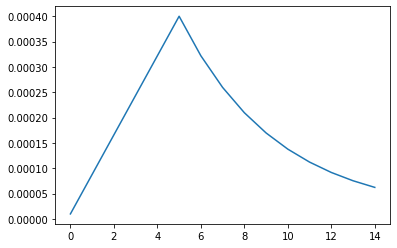

In [20]:
#define epoch parameters
EPOCHS = 15                 
STEPS_PER_EPOCH = count_data_items(TRAINING_FILENAMES) // BATCH_SIZE

#define learning rate parameters
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_DECAY = .8

#define ramp up and decay
def lr_schedule(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose = True)

#visualize learning rate schedule
rng = [i for i in range(EPOCHS)]
y = [lr_schedule(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

**Now, our final submission must commit in 3 hours or less (see [here](https://www.kaggle.com/docs/tpu)), so we have to find a balance between performance and computation time. I will define a handful of models to fine-tune and we will just have to experiment to see which delivers this perfect balance**

**Note(s): for all models below, if we did not use CutMix or mixup, we would not have one hot encoded our labels and hence we would use sparse_categorical metrics instead**

**If you decide to use an EfficientNet model for your final model, you need to install something as it is not yet supported by `keras.applications`. There is another weight option for EffNets to consider that outperforms Imagenet weights called 'Noisy Student' that you can read about [here](https://arxiv.org/abs/1911.04252). For more on EffNets in general, read [this](https://arxiv.org/pdf/1905.11946.pdf)**

In [21]:
#import DenseNet201, Xception, InceptionV3, and InceptionResNetV2
from tensorflow.keras.applications import DenseNet201, Xception, InceptionV3, InceptionResNetV2

#requirements to use EfficientNet(s)
!pip install -q efficientnet
import efficientnet.tfkeras as efn

#helper function to create our model
def get_DenseNet201():
    CLASSES = len(classes)
    with strategy.scope():
        dnet = DenseNet201(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        dnet.trainable = True
        model = tf.keras.Sequential([
            dnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy', 
        metrics=['categorical_accuracy']
    )
    return model

#create Xception model
def get_Xception():
    CLASSES = len(classes)
    with strategy.scope():
        xception = Xception(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        xception.trainable = True
        model = tf.keras.Sequential([
            xception,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

#create Inception model
def get_InceptionV3():
    CLASSES = len(classes)
    with strategy.scope():
        inception = InceptionV3(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        inception.trainable = True
        model = tf.keras.Sequential([
            inception,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

#create EfficientNetB4 model
def get_EfficientNetB4():
    CLASSES = len(classes)
    with strategy.scope():
        efficient = efn.EfficientNetB4(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

#create EfficientNetB5 model
def get_EfficientNetB5():
    CLASSES = len(classes)
    with strategy.scope():
        efficient = efn.EfficientNetB5(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model


#create EfficientNetB6 model
def get_EfficientNetB6():
    CLASSES = len(classes)
    with strategy.scope():
        efficient = efn.EfficientNetB6(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

#create EfficientNetB7 model
def get_EfficientNetB7():
    CLASSES = len(classes)
    with strategy.scope():
        efficient = efn.EfficientNetB7(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

#create InceptionResNet model
def get_InceptionResNetV2():
    CLASSES = len(classes)
    with strategy.scope():
        inception_res = InceptionResNetV2(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        inception_res.trainable = True
        model = tf.keras.Sequential([
            inception_res,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

**To make our model even more robust, we can also split our data into different folds during training. For example, if `FOLDS = 5`, we would split our data into 5 different folds, train on the first 4 folds, and then validate on the remaining fold. We then repeat this process and cycle through the folds until we have 5 different models that have been trained and validated on 5 different datasets. We then generate predictions with each one of these trained models and take the average of all 5 predictions as our final predictions:**

**(Recall that the `FOLDS` parameter was defined much earlier in the notebook as it was needed to determine the size of the validation set)**

In [22]:
from sklearn.model_selection import KFold, StratifiedKFold
#train and cross validate in folds

def cross_validate(folds = 3):
    histories = []
    models = []
    #early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
    kfold = KFold(folds, shuffle = True, random_state = SEED)
    strat_kfold = StratifiedKFold(folds, shuffle = True, random_state = SEED)
    #get data for different folds
    for f, (train_index, val_index) in enumerate(kfold.split(TRAINING_FILENAMES)):
        
        #train first fold with InceptionResNetV2
        if (f + 1) == 1:
            print(); print('-'*25)
            print('Training Fold',f+1, 'with InceptionResNetV2')
            print('-'*25)
            train_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[train_index]['TRAINING_FILENAMES']), labeled = True)
            val_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[val_index]['TRAINING_FILENAMES']), labeled = True, ordered = True)
            print('Datasets loaded')
            #train and cross validate
            model = get_InceptionResNetV2()
            history = model.fit(
                get_training_dataset(train_dataset), 
                steps_per_epoch = STEPS_PER_EPOCH,
                epochs = EPOCHS,
                callbacks = [lr_callback], #early_stopping
                validation_data = get_validation_dataset(val_dataset),
                verbose = 2)
            models.append(model)
            histories.append(history)
            
        #train second fold with DenseNet201
        if (f + 1) == 2:
            print(); print('-'*25)
            print('Training Fold',f+1, 'with DenseNet201')
            print('-'*25)
            train_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[train_index]['TRAINING_FILENAMES']), labeled = True)
            val_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[val_index]['TRAINING_FILENAMES']), labeled = True, ordered = True)
            print('Datasets loaded')
            #train and cross validate
            model = get_DenseNet201()
            history = model.fit(
                get_training_dataset(train_dataset), 
                steps_per_epoch = STEPS_PER_EPOCH,
                epochs = EPOCHS,
                callbacks = [lr_callback], #early_stopping
                validation_data = get_validation_dataset(val_dataset),
                verbose = 2)
            models.append(model)
            histories.append(history)
            
        #train third fold with EfficientNetB5
        if (f + 1) == 3:
            print(); print('-'*25)
            print('Training Fold',f+1, 'with EfficientNetB5')
            print('-'*25)
            train_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[train_index]['TRAINING_FILENAMES']), labeled = True)
            val_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[val_index]['TRAINING_FILENAMES']), labeled = True, ordered = True)
            print('Datasets loaded')
            #train and cross validate
            model = get_EfficientNetB5()
            history = model.fit(
                get_training_dataset(train_dataset), 
                steps_per_epoch = STEPS_PER_EPOCH,
                epochs = EPOCHS,
                callbacks = [lr_callback], #early_stopping
                validation_data = get_validation_dataset(val_dataset),
                verbose = 2)
            models.append(model)
            histories.append(history)
    return histories, models


def train_and_predict(folds = 3):
    #since we are splitting the dataset and iterating separately on images and ids, order matters.
    test_df = get_test_dataset(ordered = True)
    test_images_df = test_df.map(lambda image, idnum: image)
    print('Start training %i folds'%folds)
    histories, models = cross_validate(folds = folds)
    print('Computing predictions...')
    #get the mean probability of the models from each fold
    probabilities = np.average([models[i].predict(test_images_df) for i in range(folds)], axis = 0)
    predictions = np.argmax(probabilities, axis = -1)
    print('Generating submission.csv file...')
    test_ids_df = test_df.map(lambda image, idnum: idnum).unbatch()
    #all in one batch
    test_ids = next(iter(test_ids_df.batch(NUM_TEST_IMAGES))).numpy().astype('U')
    np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt = ['%s', '%d'], 
               delimiter = ',', header='id,label', comments = '')
    return histories, models

In [23]:
#run train and predict
histories, models = train_and_predict(folds = FOLDS)

Start training 3 folds

-------------------------
Training Fold 1 with InceptionResNetV2
-------------------------
Datasets loaded

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/15
128/128 - 88s - loss: 4.3141 - categorical_accuracy: 0.1272 - val_loss: 3.4016 - val_categorical_accuracy: 0.2737 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/15
128/128 - 52s - loss: 2.3235 - categorical_accuracy: 0.5469 - val_loss: 0.7671 - val_categorical_accuracy: 0.8256 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/15
128/128 - 52s - loss: 1.5018 - categorical_accuracy: 0.7403 - val_loss: 0.6855 - val_categorical_accuracy: 0.8563 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/15
128/128 - 53s - loss: 1.2977 - categorical_accuracy: 0.7883 - val_loss: 0.6381 - val_categorical_accuracy: 0.8685 - lr: 2.4400e-04

Epoch 00005: Lea

In [24]:
#define function to visualize learning curves
def plot_learning_curves(histories): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))
    
    #plot accuracies
    ax[0].plot(histories[0].history['categorical_accuracy'], color = 'C0')
    ax[0].plot(histories[0].history['val_categorical_accuracy'], color = 'C1')
    ax[0].plot(histories[1].history['categorical_accuracy'], color = 'C0')
    ax[0].plot(histories[1].history['val_categorical_accuracy'], color = 'C1')
    ax[0].plot(histories[2].history['categorical_accuracy'], color = 'C0')
    ax[0].plot(histories[2].history['val_categorical_accuracy'], color = 'C1')
    
    #plot losses
    ax[1].plot(histories[0].history['loss'], color = 'C0')
    ax[1].plot(histories[0].history['val_loss'], color = 'C1')
    ax[1].plot(histories[1].history['loss'], color = 'C0')
    ax[1].plot(histories[1].history['val_loss'], color = 'C1')
    ax[1].plot(histories[2].history['loss'], color = 'C0')
    ax[1].plot(histories[2].history['val_loss'], color = 'C1')
    
    #fix legend
    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper right')
    
    #set master titles
    fig.suptitle("Model Performance", fontsize=14)
    
    #label axis
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

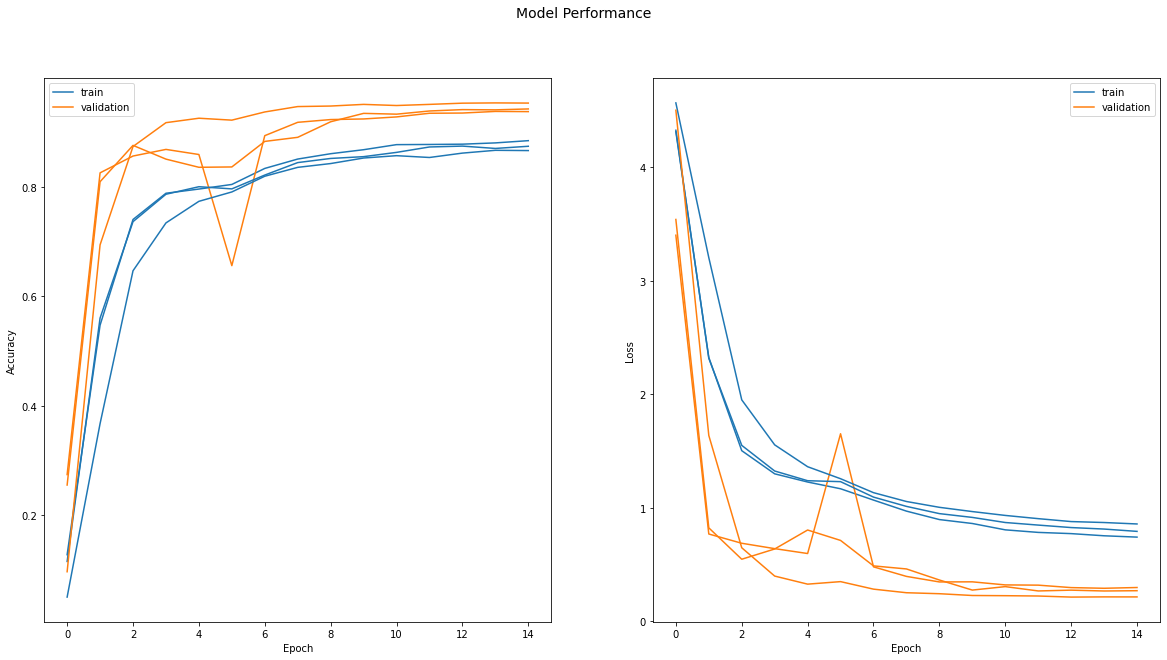

In [25]:
#look at our learning curves to check bias/variance trade off
plot_learning_curves(histories)